<a href="https://colab.research.google.com/github/ayeffkay/Notebooks/blob/master/multi_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-style transfer

This notebook implements two approaches to the multi-style transfer: **A Neural algorithm of artistic style** (by  [Gatys et al.](https://arxiv.org/pdf/1508.06576.pdf)) with linear blending and **Semantic-aware Multi-Style Transfer Network** (by [Zixuan Huang et al.](https://arxiv.org/pdf/1910.13093.pdf))

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from collections import OrderedDict

import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

from torch.utils.data import Dataset, DataLoader
import glob, os
from IPython.display import clear_output

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [0]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Dataloader

**Datasets**


1.   Content (landscape pictures): https://www.kaggle.com/arnaud58/landscape-pictures
2.   Style1 (abstract art): https://www.kaggle.com/greg115/abstract-art
3. Style2 (segmented Bob Ross paintings): https://www.kaggle.com/residentmario/segmented-bob-ross-images



In [0]:
%%bash
mkdir -p content && unzip 'drive/My Drive/landscapes.zip' -d content
mkdir -p style1_tmp && unzip 'drive/My Drive/abstract_art.zip' -d style1_tmp
mkdir -p style2_tmp && unzip 'drive/My Drive/paintings.zip' 'train/images/*' -d style2_tmp

In [0]:
%%bash
mkdir -p style1 && mv style1_tmp/abstract_art_512/* style1 && rm -rf style1_tmp
mkdir -p style2 && mv style2_tmp/train/images/* style2 && rm -rf style2_tmp

In [0]:
# png to jpg
for root, dirs, files in os.walk("style2", topdown=False):
    for name in files:
        old_name = os.path.basename(name)
        new_name = os.path.splitext(old_name)[0] + '.jpg'
        im = Image.open(os.path.join(root, old_name))
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join(root, new_name))
        os.remove(os.path.join(root, old_name))

In [0]:
class ImagesDataset(Dataset):
    def __init__(self, content_folder, style_folders, img_size=128, n=100, device=DEVICE):
        super(ImagesDataset, self).__init__()
        self.size = n
        self.img_size = img_size
        self.device = device

        self.content = self.get_img_names(content_folder, n)
        self.styles = [self.get_img_names(folder, n) for folder in style_folders]
        
        self.resize = transforms.Compose([transforms.Resize(self.img_size),
                                     transforms.CenterCrop(self.img_size)])
        self.tensor = transforms.ToTensor()

    def get_img_names(self, folder, n):
        ext = '*.jpg'
        path = os.path.join(folder, ext)
        files = np.array(glob.glob(path))
        idxs = np.random.choice(len(files), size=n, replace=False)
        return files[idxs].tolist()

    def __len__(self):
        return self.size

    def load_img(self, path):
        img = Image.open(path)
        img.load()
        return img

    def transform(self, img):
        img = np.array(self.resize(img))
        img = (img / 255).astype('float32')
        return self.tensor(img)

    def __getitem__(self, id):
        content = self.load_img(self.content[id])
        styles = [self.load_img(style[id]) for style in self.styles]

        content = self.transform(content).to(self.device)
        styles = [self.transform(style).to(self.device) for style in styles]

        return {'content': content, 'styles': styles}

In [0]:
def imshow(tensor, title=None, plt_ax=plt, default=False):
    array = tensor.squeeze(0).numpy().transpose((1, 2, 0))
    array = np.clip(array, 0, 1)
    plt_ax.imshow(array)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    plt_ax.axis('off')

In [0]:
def imshow_group(tensors, nrows=1, ncols=1, titles=None):
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5),
                            sharey=True, sharex=True)
    for i, fig_x in enumerate(ax.flatten()):
        imshow(tensors[i].data.cpu(), title=titles[i] if titles else None, 
               plt_ax=fig_x)
    plt.show()

In [0]:
dataset = ImagesDataset('content', ['style1', 'style2'], n=250)

In [0]:
tmp_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [0]:
sample = next(iter(tmp_loader))
cnt = sample['content']
st1, st2 = sample['styles']

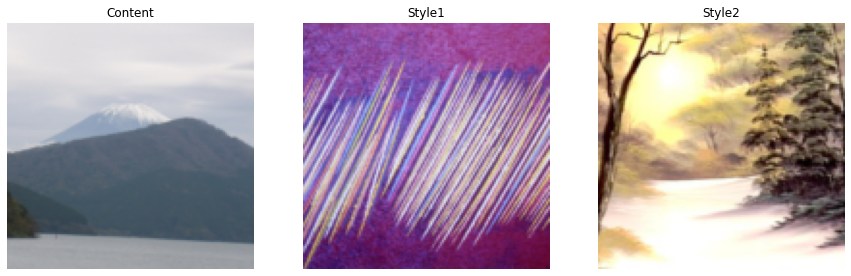

In [15]:
imshow_group([cnt, st1, st2], nrows=1, ncols=3, titles=['Content', 'Style1', 'Style2'])

## Neural-Style algorithm

### Losses

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.data

    def forward(self, input):
        loss = F.mse_loss(input, self.target)
        return loss

In [0]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target.data)

    def gram_matrix(self, x):
        # [B x C x H x W]
        b, c, h, w = x.size()
        features = x.view(b * c, h * w) 

        G = torch.mm(features, features.t())
        return G.div(b * c * h * w)

    def forward(self, input):
        G = self.gram_matrix(input)
        loss = F.mse_loss(G, self.target)
        return loss

### Normalization

In [0]:
MEAN = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
STD = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

class Normalization(nn.Module):
    def __init__(self, mean=MEAN, std=STD):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

### Feature extractor

In [0]:
resnet = models.resnet18(pretrained=True).to(DEVICE).eval()
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, content_layers, style_layers, 
                 content_img, style_imgs, inverse_style_wghts=False,
                 content_wght=1, style_wght=1e+3, tv_wght=1e-2):
        super(FeatureExtractor, self).__init__()

        self.content_layers = content_layers
        self.style_layers = style_layers

        self.layers = self.build_from_resnet(model)
        self.content_losses, self.style_losses = self.add_losses(content_img, style_imgs)

        self.inverse_style_wghts = inverse_style_wghts
        self.content_wght = content_wght
        self.style_wght = style_wght
        self.tv_wght = tv_wght


    def build_from_resnet(self, model):
        layers = nn.ModuleDict()

        # separate packing for layer0
        layer0 = nn.Sequential()
        layer0.add_module('input_norm', Normalization())
        for name, layer in list(model.named_children())[:4]:
            layer0.add_module(name, layer)
        layers.update({'layer0': layer0})

        for name, layer in list(model.named_children())[4:]:
            if name == 'avgpool':
                break
            layers.update({name: layer})
            
        return layers

    
    def add_losses(self, content, styles):
        content_losses = nn.ModuleDict()
        style_losses = nn.ModuleDict()

        c = content.clone()
        styles_ = [style.clone() for style in styles]

        for name, layer in self.layers.items():
            c = layer(c)
            styles_ = [layer(style) for style in styles_]

            if name in self.content_layers:
                content_losses.update({name: ContentLoss(c)})

            if name in self.style_layers:
                losses = nn.ModuleList([StyleLoss(style) for style in styles_])
                style_losses.update({name: losses})

        return content_losses, style_losses


    # for regularization
    def total_variation(self, x):
        a = (x[:, :, :-1, :] - x[:, :, 1:, :]) ** 2
        b = (x[:, :, :, :-1] - x[:, :, :, 1:]) ** 2
        return torch.sum(a + b.permute(0, 1, 3, 2))


    def forward(self, x):
        content_score = 0
        style_score = 0

        for name, layer in self.layers.items():
            x = layer(x)
            
            if name in self.content_layers:
                content_score += self.content_losses[name](x)

            if name in self.style_layers:
                # for weights only
                with torch.no_grad():
                    layer_style_losses = torch.tensor([loss(x) \
                                                       for loss in self.style_losses[name]])
                    if self.inverse_style_wghts:
                         layer_style_weights = torch.sum(layer_style_losses) / layer_style_losses
                    else:
                        layer_style_weights = layer_style_losses / torch.sum(layer_style_losses)

                for i, loss in enumerate(self.style_losses[name]):
                    # different weights for each style per layer
                    style_score += layer_style_weights[i].item() * loss(x)

        loss = self.content_wght * content_score + \
                self.style_wght * style_score + \
                self.tv_wght * self.total_variation(x)
        return loss

### Training

In [0]:
def get_optimizer(input_img):
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
content_layers = ['layer3']
style_layers = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4']

In [0]:
def run_style_transfer(resnet, content_img, style_imgs, inv_style_w=False,
                       content_wght=1, style_wght=1e+5, tv_wght=1e-3, 
                       epochs=100):
    model = FeatureExtractor(resnet, content_layers, style_layers, 
                             content_img, style_imgs, inv_style_w, 
                             content_wght, style_wght, tv_wght)
    input_img = 1e-3 * torch.randn_like(content_img) + content_img.clone()
    optimizer = get_optimizer(input_img)

    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            input_img.data.clamp_(0, 1)
            loss = model.forward(input_img)
            loss.backward()
            optimizer.step(lambda: loss)
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                pbar.write('Loss: {:.4f}'.format(loss.item()))
            pbar.update(1)
    return input_img

In [86]:
img1 = run_style_transfer(resnet, cnt, [st1], epochs=300)

 34%|███▍      | 102/300 [00:03<00:07, 26.11it/s]

Loss: 2.7965


 68%|██████▊   | 204/300 [00:07<00:03, 25.41it/s]

Loss: 2.3862


100%|██████████| 300/300 [00:10<00:00, 27.61it/s]

Loss: 2.2610


In [87]:
img2 = run_style_transfer(resnet, cnt, [st2], epochs=300)

 35%|███▌      | 105/300 [00:03<00:07, 26.16it/s]

Loss: 1.1883


 68%|██████▊   | 204/300 [00:07<00:03, 24.97it/s]

Loss: 1.0510


100%|██████████| 300/300 [00:10<00:00, 27.69it/s]

Loss: 1.0261


In [88]:
img12 = run_style_transfer(resnet, cnt, [st1, st2], epochs=500)

 20%|██        | 102/500 [00:03<00:15, 25.44it/s]

Loss: 4.2512


 41%|████      | 204/500 [00:07<00:11, 24.67it/s]

Loss: 4.1880


 61%|██████    | 303/500 [00:11<00:08, 24.51it/s]

Loss: 4.1725


 80%|████████  | 402/500 [00:15<00:04, 24.35it/s]

Loss: 4.1650


100%|██████████| 500/500 [00:19<00:00, 25.85it/s]

Loss: 4.1608


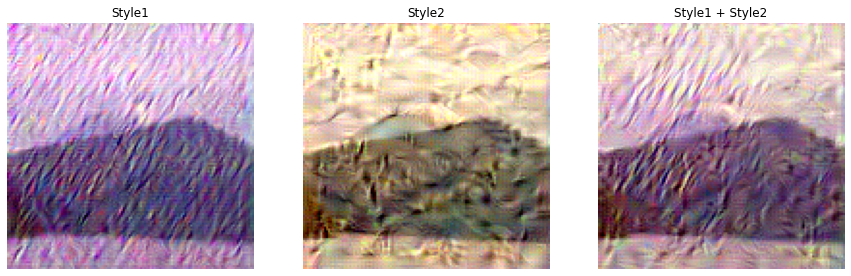

In [89]:
titles = ['Style1', 'Style2', 'Style1 + Style2']
imshow_group([img1, img2, img12], ncols=3, titles=titles)

## Style Mixer


### Model

In [0]:
vgg = models.vgg11(pretrained=True).features.eval()
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
# expected input: [relu_3_1, relu_4_1, relu_5_1]
class FeatureFusion(nn.Module):
    def __init__(self):
        super(FeatureFusion, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(256, 256, 1), 
                                  nn.Conv2d(512, 256, 1), 
                                  nn.Conv2d(512, 256, 1)])
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(nn.Linear(3 * 256, 256, bias=False),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, 256 * 3, bias=False),
                                nn.Sigmoid())
        self.out_conv = nn.Conv2d(3 * 256, 512, 3, padding=1)
    

    def forward(self, features):
        # recalibration
        features_conv = [conv(features[i]) for i, conv in enumerate(self.conv)]

        # rescale to middle shape (first feature)
        rescale_size = features_conv[1].size()
        features_conv[0] = F.interpolate(features_conv[0], size=rescale_size[2:], 
                                         mode='bilinear', align_corners=True)
        features_conv[2] = F.interpolate(features_conv[2], size=rescale_size[2:], 
                                         mode='bilinear', align_corners=True)

        # concat by channels
        features_conv = torch.cat(features_conv, dim=1)
        b, c, h, w = features_conv.size()

        pool = self.pool(features_conv).view(b, c)
        # attention weights
        weights = self.fc(pool).view(b, c, 1, 1)
        # channel-wise attention
        weighted_features =  features_conv * weights.expand_as(features_conv)
        
        return self.out_conv(weighted_features)

In [0]:
# expected input: [relu_4_1 (content), relu_4_1 (style), F_s_fused]
class PatchAttention(nn.Module):
    def __init__(self):
        super(PatchAttention, self).__init__()
        self.in_conv = nn.ModuleList([nn.Conv2d(512, 256, 1), 
                                     nn.Conv2d(512, 256, 1),
                                     nn.Conv2d(512, 256, 1)])

        self.unfold_c = nn.Unfold(3, padding=1)
        self.unfold_s = nn.Unfold(3, padding=1)

        self.out_conv = nn.Conv2d(256, 512, 1)

    def forward(self, F_c, F_s, F_s_fused):
        # channel-wise normalization
        F_c_ = F.normalize(F_c, dim=1)
        F_s_ = F.normalize(F_s, dim=1)

        # 1d convolutions
        b, c, _, _ = F_s_fused.size()
        F_c1, F_s1, F_s_fused1 = [self.in_conv[i](F) for i, F in enumerate([F_c, F_s, F_s_fused])]
        b, c1, h, w = F_s_fused1.size()

        # unfolding
        F_c1_unfold = self.unfold_c(F_c1).permute(0, 2, 1)
        F_s1_unfold = self.unfold_s(F_s1)
        F_s_fused1 = F_s_fused1.view(b, c1, -1)

        # correspondence score
        S = torch.matmul(F_c1_unfold, F_s1_unfold)
        # semantic attention map
        M = F.softmax(S, dim=-1)
        # correspondence confidence
        C = torch.sum(S * M, dim=-1).view(b, 1, h * w)

        # reassembled style feature
        F_s_fused_weighted = torch.matmul(F_s_fused1, M).view(b, c1, h, w)
        return C, self.out_conv(F_s_fused_weighted).view(b, c, -1)

In [0]:
class MultiStyleFusion(nn.Module):
    def __init__(self):
        super(MultiStyleFusion, self).__init__()

    def forward(self, C, F_s_fused):
        b, c, hw = F_s_fused[0].size()
        fused_styles = torch.cat(F_s_fused, dim=1).view(b, -1, c, hw)

        # sort of discrete argmax by styles :)
        C = torch.cat(C, dim=1).view(b, -1, hw)
        I = C.max(dim=1, keepdim=True)[0]
        mask = (C >= I).unsqueeze(2)

        return torch.sum(fused_styles * mask, dim=1)

In [0]:
class StyleMixer(nn.Module):
    def __init__(self, model, split_layers, feat_fusion_layers, patch_attn_layers, n_styles, decoder_cfg):
        super(StyleMixer, self).__init__()
        
        self.feat_fusion_layers = feat_fusion_layers
        self.patch_attn_layers = patch_attn_layers
        self.n_styles = n_styles

        layers = self.parse_layers(model)
        self.encoder = self.split_blocks(layers, split_layers)
        self.feat_fusion_content = FeatureFusion()
        self.feat_fusion_style = nn.ModuleList([FeatureFusion() for i in range(n_styles)])
        self.patch_attn = nn.ModuleList([PatchAttention() for i in range(n_styles)])
        self.style_fusion = MultiStyleFusion()
        # amplifier
        self.K = nn.Parameter(torch.rand(1))

        self.decoder = self.build_decoder(decoder_cfg)

    @staticmethod
    def parse_layers(model):
        layers = nn.Sequential()
        i = 1; j = 1
        layers.add_module('input_norm', Normalization())
        for layer in model.children():
            if isinstance(layer, nn.Conv2d):
                layers.add_module('{}_{}_{}'.format('conv', i, j), layer)
            elif isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=True)
                layers.add_module('{}_{}_{}'.format('relu', i, j), layer)
                j += 1
            elif isinstance(layer, nn.MaxPool2d):
                layers.add_module('{}_{}'.format('pool', i), layer)
                i += 1
                j = 1
            else:
                raise RuntimeError('Unrecognized layer {}'.format(layer.__class__.__name__))
        return layers
    
    @staticmethod
    def split_blocks(model, split_layers):
        layers = nn.ModuleDict()
        block = nn.Sequential()

        for name, layer in model.named_children():
            block.add_module(name, layer)

            if name in split_layers:
                layers.update({name: block})
                block = nn.Sequential()

        return layers

    def build_decoder(self, config):
        decoder = nn.Sequential()
        for i, layer in enumerate(config):
            decoder.add_module(f'{i}', self.decoder_block(*layer))
        return decoder

    def decoder_block(self, in_channels, out_channels, kernel=3, n=2, last=False):
        block = []
        for i in range(n):
            if i == n - 1:
                block += [nn.Conv2d(in_channels, out_channels, kernel, padding=1)]
                if not last:
                    block += [nn.ReLU(inplace=True)]
                    block += [nn.ConvTranspose2d(out_channels, out_channels, 
                                                 2, stride=2)]
            else:
                block += [nn.Conv2d(in_channels, in_channels, kernel, padding=1)]
                block += [nn.ReLU(inplace=True)]
        return nn.Sequential(*block)

    def get_fusion_features(self, features, transpose=False):
        tmp = [f for name, f in features.items() if name in self.feat_fusion_layers]
        # 'transpose', to [n_styles x n_layers x B x C x H x W]
        return [list(col) for col in zip(*tmp)] if transpose else tmp

    def get_attn_features(self, features):
        tmp = [f for name, f in features.items() if name in self.patch_attn_layers]
        return tmp

    def fusion(self, content_features, style_features, mode):
        # [B x 512 x H x W]
        F_c_fusion = self.get_fusion_features(content_features)
        F_c_fused = self.feat_fusion_content(F_c_fusion)

        F_s_fusion = self.get_fusion_features(style_features, transpose=True)
        # [n_styles x B x 512 x H x W]
        F_s_fused = [feat_fusion(F_s_fusion[i]) \
                     for i, feat_fusion in enumerate(self.feat_fusion_style)]

        F_c_attn = self.get_attn_features(content_features)[0]
        F_s_attn = self.get_attn_features(style_features)[0]
        C = [] # [n_styles x B x 1 x H*W]
        F_s_fused_ = [] # [n_styles x B x 512 x H*W]
        for i, attn in enumerate(self.patch_attn):
            conf, feat = attn(F_c_attn, F_s_attn[i], F_s_fused[i])
            C.append(conf); F_s_fused_.append(feat)

        b, c, h, w = F_c_fused.size()
        # output: [B x 512 x H x W]
        if self.n_styles == 1:
            if mode == 'eval':
                return self.K * F_s_fused_[0].view(b, c, h, w)
            return F_c_fused + F_s_fused_[0].view(b, c, h, w)
        else:
            F_s_fused_total = self.style_fusion(C, F_s_fused_)
            if mode == 'eval':
                return self.K * F_s_fused_total.view(b, c, h, w)
            return F_c_fused + F_s_fused_total.view(b, c, h, w)
        

    def forward(self, content, styles, mode='train'):
        content_features = OrderedDict()
        style_features = OrderedDict()

        cnt = content.clone()
        sts = [style.clone() for style in styles]

        for name, layer in self.encoder.items():
            cnt = layer(cnt)
            sts = [layer(st) for st in sts]

            content_features[name] = cnt
            style_features[name] = sts

        # [B x 512 x H x W]
        fused = self.fusion(content_features, style_features, mode)
        out = self.decoder(fused)
        # return content and style features to calculate losses
        return out, content_features, style_features

### Losses

In [0]:
def mean_std(x, eps=1e-6):
    b, c, h, w = x.size()

    var = x.view(b, c, -1).var(dim=2) + eps
    std = var.sqrt().view(b, c, 1, 1)
    mean = x.view(b, c, -1).mean(dim=2).view(b, c, 1, 1)
    return mean, std

In [0]:
def normalized_mean_std(input, target, eps=1e-6):
    size = target.size()
    i_mean, i_std = mean_std(input, eps)
    t_mean,t_std = mean_std(target, eps)
    i_normalized = (input - i_mean.expand(size)) / (i_std.expand(size) + eps)
    t_normalized = (target - t_mean.expand(size)) / (t_std.expand(size) + eps)
    return i_normalized, t_normalized

In [0]:
def content_loss(input, target):
    i_norm, t_norm = normalized_mean_std(input, target)
    loss = F.mse_loss(i_norm, t_norm)
    return loss

Style loss from 
[AdaIN](https://arxiv.org/pdf/1703.06868.pdf).

In [0]:
def style_loss_in(style, output):
    style_mean, style_std = mean_std(style)
    output_mean, output_std = mean_std(output)

    loss = F.mse_loss(output_mean, style_mean) + F.mse_loss(output_std, style_std)
    return loss

In [0]:
def normalize(x, eps=1e-6):
    norm = x.norm(dim=1, keepdim=True)
    return x.div(norm + eps)

In [0]:
def context_loss(style, output, eps=1e-6, bw=0.1):
    b, c, h, w = style.size()

    style = normalize(style).view(b, c, -1)
    output = normalize(output).view(b, c, -1)
    
    style_t = style.permute(0, 2, 1)

    # 1 - cosine similarity (by definition, scalar product of normalized vectors)
    rho = 1 - torch.matmul(style_t, output)
    
    # normalization
    rho_min = torch.min(rho, dim=-1, keepdim=True)[0] + eps
    rho_norm = rho / rho_min

    # affinity
    logit = torch.exp((1 - rho_norm) / bw)
    A = logit / torch.sum(logit, dim=-1, keepdim=True)

    total_cx = torch.mean(torch.max(A, dim=1)[0], dim=-1)
    loss = -torch.log(total_cx)

    return loss.mean()

In [0]:
def identity_loss(style, content, output):
    loss = F.mse_loss(output, content) + F.mse_loss(output, style)
    return loss

In [0]:
def compute_loss(model, content, styles, output, content_features, style_features,
                 content_layers, style_layers, context_layers):
    style_score, content_score, context_score, identity_score = 0, 0, 0, 0
    ls, lc, lcx, l_i1, l_i2, w = 5, 1, 5, 1, 10, 1 / len(styles)
    
    output1, _, _ = model.forward(content, styles, mode='eval')
    for style in styles: # identity between input and output
        identity_score += l_i1 * w * identity_loss(style, content, output1)

    for name, layer in model.encoder.items():

        output = layer(output)

        for style in style_features[name]: # identity between feature maps
            identity_score += l_i2 * w * identity_loss(style, content_features[name], output)

        if name in style_layers:
            for style in style_features[name]:
                style_score += w * style_loss_in(style, output)

        if name in content_layers:
            content_score += content_loss(output, content_features[name])

        if name in context_layers:
            for style in style_features[name]:
                context_score += w * context_loss(style, output)
    return ls * style_score + lc * content_score + lcx * context_score + identity_score

### Training

In [0]:
split_layers = ['relu_1_1', 'relu_2_1', 'relu_3_1', 'relu_4_1', 'relu_5_1']
content_layers = ['relu_3_1', 'relu_4_1', 'relu_5_1']
style_layers = ['relu_1_1', 'relu_2_1', 'relu_3_1', 'relu_4_1']
context_layers = ['relu_2_1', 'relu_3_1', 'relu_4_1']
fusion_layers = ['relu_3_1', 'relu_4_1', 'relu_5_1']
attn_layers = ['relu_4_1']
n_styles = 2

# in_channels, out_channels, kernel, n_blocks, is_last
decoder_cfg = [[512, 256, 3, 2, 0], [256, 128, 3, 2, 0], 
               [128, 64, 3, 1, 0], [64, 3, 3, 1, 1]]

In [0]:
def show_tmp(model, content=None, styles=None):
    model.eval()
    titles = ['Content', 'Style1', 'Style2', 'Output']
    with torch.no_grad():
        if content is None or styles is None:
            content = cnt; styles = [st1, st2] # images from tmp_loader
        out, _, _ = model.forward(content, styles)
        imshow_group([content] + styles + [out], ncols=4, titles=titles)

In [0]:
def train(model, optim, dataloader, epochs):
    min_loss = 1e+5
    best_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        for batch in dataloader:
            optim.zero_grad()
            noise = 1e-4 * torch.randn_like(batch['content'])
            out, content_features, style_features = model.forward(batch['content'] + noise, batch['styles'])
            loss = compute_loss(model, batch['content'] + noise, batch['styles'], out, 
                                content_features, style_features,
                                content_layers, style_layers, context_layers)
            loss.backward()
            optim.step()

            epoch_loss += loss.item()

        show_tmp(model)
        print(f'{epoch + 1} / {epochs} epochs : loss {epoch_loss / len(dataloader)}')
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_wts)

In [0]:
style_mixer = StyleMixer(vgg, split_layers, fusion_layers, 
               attn_layers, n_styles, decoder_cfg).to(DEVICE)

In [51]:
len(dataset)

250

In [0]:
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [0]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, style_mixer.parameters()), lr=1e-4)

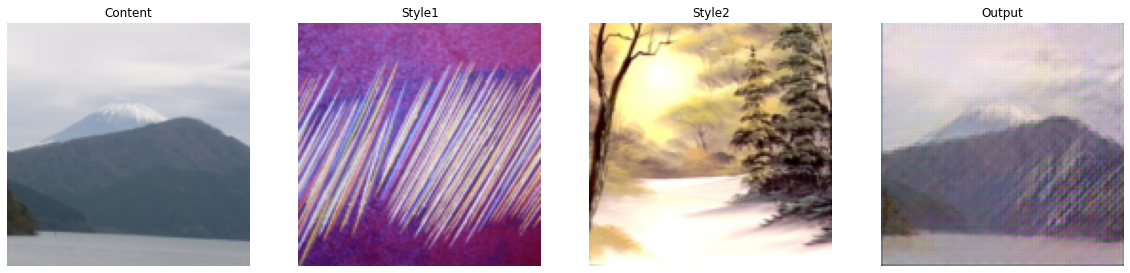

200 / 200 epochs : loss 210.00470399856567


In [54]:
train(style_mixer, optimizer, train_loader, 200)

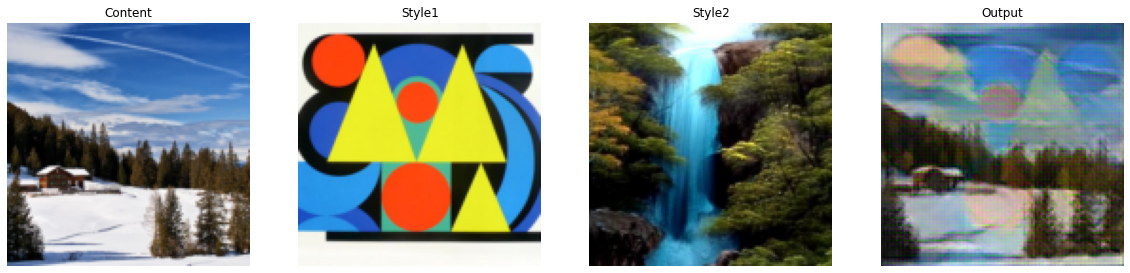

In [55]:
sample1 = next(iter(train_loader))
show_tmp(style_mixer, sample1['content'][0].unsqueeze(0), 
         [sample1['styles'][0][0].unsqueeze(0), sample1['styles'][1][0].unsqueeze(0)])